In [1]:
%load_ext autoreload
%autoreload 2

# Load packages

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata
from sklearn.metrics import precision_recall_curve, auc

import scvi
import shutil

from oor_benchmark.methods.scArches_milo import run_milo

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

/data/chenyx/anaconda3/envs/oor-benchmark-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
figdir = '/nfs/public/chenyx/OOR/result/COVID_fig/'
if not os.path.exists(figdir):
    os.mkdir(figdir)
sc.settings.figdir = figdir

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)
library(ggrastr)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

In addition: Warning message:
package ‘reshape2’ was built under R version 4.2.1 


In [7]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6], "CR scMulan":pal[1]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [8]:
%%R -i design_palette_df -i figdir
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

In [9]:
from adjustText import adjust_text
import matplotlib.patheffects as pe

def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [10]:
def plot_w_ggplot(r_fct_str, args, figdir='.', pl_name='plot', pl_width=8, pl_height=8):

    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP

    r_pkg = STAP(r_fct_str, "r_pkg")
    #this was needed for the code to run on jhub
    #if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    pl = r_pkg.plot_func(args)
    
    ggsave_str = '''
    save_plot <- function(pl, figdir, pl_name, pl_width, pl_height){
        pl + 
        ggsave(file.path(figdir, paste0(pl_name, ".png")), width=pl_width, height=pl_height)  +
        ggsave(file.path(figdir, paste0(pl_name, ".pdf")), width=pl_width, height=pl_height)
    }
    
    '''
    r_save = STAP(ggsave_str, "r_save")
    r_save.save_plot(pl, figdir, pl_name=pl_name, pl_width=pl_width, pl_height=pl_height)
    

## load data and embeddings

In [ ]:
# load data
data_dir = "/data/bhy/cell_gpt_data/dataHub/datasets/reference_generation_datasets/paper_adata/"
adata_atlas = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.atlas.h5ad')
adata_covid = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.covid.h5ad')
adata_ctrl = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.ctrl.h5ad')

emb_atlas = sc.read_h5ad("/data/bhy/cell_gpt_data/output/atlas_embed.h5ad")
adata_atlas = adata_atlas[emb_atlas.obs.index,:]
adata_atlas.obsm['X_scMulan'] = emb_atlas.X

emb_covid = sc.read_h5ad("/data/bhy/cell_gpt_data/output/disease_embed.h5ad")
adata_covid = adata_covid[emb_covid.obs.index,:]
adata_covid.obsm['X_scMulan'] = emb_covid.X

emb_ctrl = sc.read_h5ad("/data/bhy/cell_gpt_data/output/control_embed.h5ad")
adata_ctrl = adata_ctrl[emb_ctrl.obs.index,:]
adata_ctrl.obsm['X_scMulan'] = emb_ctrl.X

In [ ]:
adata_atlas.write_h5ad("/nfs/public/chenyx/OOR/data/PBMC_COVID.subsample500cells.atlas.trans.h5ad")
adata_covid.write_h5ad("/nfs/public/chenyx/OOR/data/PBMC_COVID.subsample500cells.atlas.covid.h5ad")
adata_ctrl.write_h5ad("/nfs/public/chenyx/OOR/data/PBMC_COVID.subsample500cells.atlas.ctrl.h5ad")

## Milo analysis

### Prepare data

In [11]:
adata_design = sc.read_h5ad("/nfs/public/chenyx/OOR/data/PBMC_COVID.subsample500cells.design.query_P_refC.post_milo.h5ad")

In [12]:
adata_design 

AnnData object with n_obs × n_vars = 62509 × 24727
    obs: 'n_genes', 'total_counts_mt', 'pct_counts_mt', 'initial_clustering', 'Resample', 'Collection_Day', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'dataset_group', 'IF

In [13]:
adata_covid = sc.read_h5ad("/nfs/public/chenyx/OOR/data/PBMC_COVID.subsample500cells.atlas.covid.h5ad")
adata_ctrl = sc.read_h5ad("/nfs/public/chenyx/OOR/data/PBMC_COVID.subsample500cells.atlas.ctrl.h5ad")
adata = sc.concat({'Covid': adata_covid, 'Healthy': adata_ctrl},label="Status")

In [14]:
adata_design.obsm['X_scMulan'] = adata[adata_design.obs.index].obsm['X_scMulan']

In [15]:
adata_design

AnnData object with n_obs × n_vars = 62509 × 24727
    obs: 'n_genes', 'total_counts_mt', 'pct_counts_mt', 'initial_clustering', 'Resample', 'Collection_Day', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'dataset_group', 'IF

In [16]:
sc.pp.neighbors(adata_design, use_rep="X_scMulan", n_neighbors=100)

/data/chenyx/anaconda3/envs/oor-benchmark-env/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [17]:
sc.tl.umap(adata_design)

In [18]:
adata_design

AnnData object with n_obs × n_vars = 62509 × 24727
    obs: 'n_genes', 'total_counts_mt', 'pct_counts_mt', 'initial_clustering', 'Resample', 'Collection_Day', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'dataset_group', 'IF

### Run differential analysis

In [19]:
run_milo(adata_design, 'P', 'C', sample_col='sample_id', annotation_col='cell_type', design='~Site+is_query')
milopy.utils.annotate_nhoods_continuous(adata_design, "IFN_signature")
milopy.utils.annotate_nhoods(adata_design, 'author_cell_type')

/data/chenyx/anaconda3/envs/oor-benchmark-env/lib/python3.10/site-packages/scipy/sparse/_base.py:713: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)


### add board

In [20]:
anno_labels = adata_design.obs['author_cell_type'].unique()
anno_groups = {}
anno_groups['B_cell'] = [x for x in adata_design.obs['author_cell_type'].unique() if x.startswith('B_')]
anno_groups['HSPC'] = [x for x in adata_design.obs['author_cell_type'].unique() if x.startswith('HSC_')]
anno_groups['CD14_mono'] =[x for x in adata_design.obs['author_cell_type'].unique() if 'CD14_mono' in x]
anno_groups['CD16_mono'] =[x for x in adata_design.obs['author_cell_type'].unique() if 'CD16_mono' in x]
anno_groups['CD4_T'] =[x for x in adata_design.obs['author_cell_type'].unique() if x.startswith("CD4.")]
anno_groups['CD8_T'] =[x for x in adata_design.obs['author_cell_type'].unique() if x.startswith("CD8.")]
anno_groups['ILC'] =[x for x in adata_design.obs['author_cell_type'].unique() if x.startswith("ILC")]
anno_groups['Plasma_cell'] =[x for x in adata_design.obs['author_cell_type'].unique() if x.startswith("Plasma_cell")]

for x in anno_labels: 
    if x not in sum(anno_groups.values(), []):
        anno_groups[x] = [x]

anno_labels_dict = {x:k for k,v in anno_groups.items() for x in v}

adata_design.obs['author_cell_type_broad'] = [anno_labels_dict[x] for x in adata_design.obs['author_cell_type']]

### Umap plot

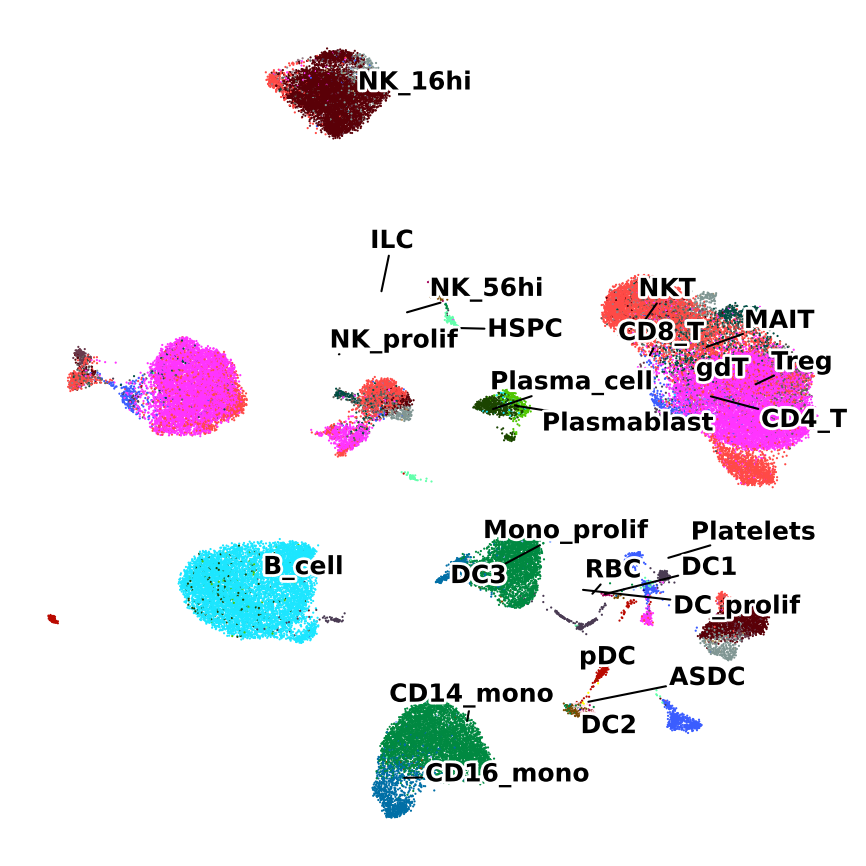

In [21]:
with rc_context({'figure.figsize':[9,9]}):
    ax = sc.pl.umap(adata_design, color=['author_cell_type_broad'], size=10, palette=sc.pl.palettes.godsnot_102,
                legend_fontsize=14, frameon=False,
                title="", show=False, legend_loc=None)
    scatterplot = ax.collections[0]
    scatterplot.set_rasterized(True)
    gen_mpl_labels(
        adata_design,
        "author_cell_type_broad",
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=18, fontweight='bold', path_effects=[pe.withStroke(linewidth=4, foreground="white")]),
    )
    fig = ax.get_figure()
    fig.tight_layout()
    plt.savefig(figdir + "CR_design_celltypes.pdf")

In [28]:
with rc_context({'figure.figsize':[20,20]}):
    sc.pl.umap(adata_design, color=['author_cell_type_broad'], size=10, palette=sc.pl.palettes.godsnot_102,
                    legend_fontsize=14, frameon=False,
                    title="", show=False, legend_loc=None, save="cell_type.pdf")

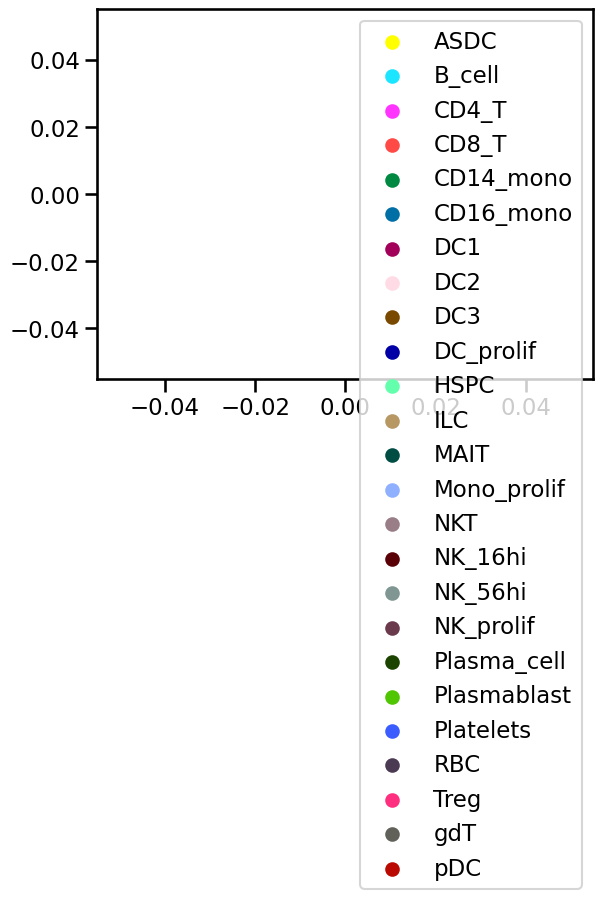

In [31]:
plt.scatter([], [])

colors = adata_design.uns['author_cell_type_broad_colors']
labels = adata_design.obs.author_cell_type_broad.cat.categories

for color, label in zip(colors, labels):
    plt.scatter([], [], c=color, label=label)

plt.legend()
plt.savefig("cell_type_Legend.pdf") 
plt.show()

/data/chenyx/anaconda3/envs/oor-benchmark-env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


/data/chenyx/anaconda3/envs/oor-benchmark-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/data/chenyx/anaconda3/envs/oor-benchmark-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


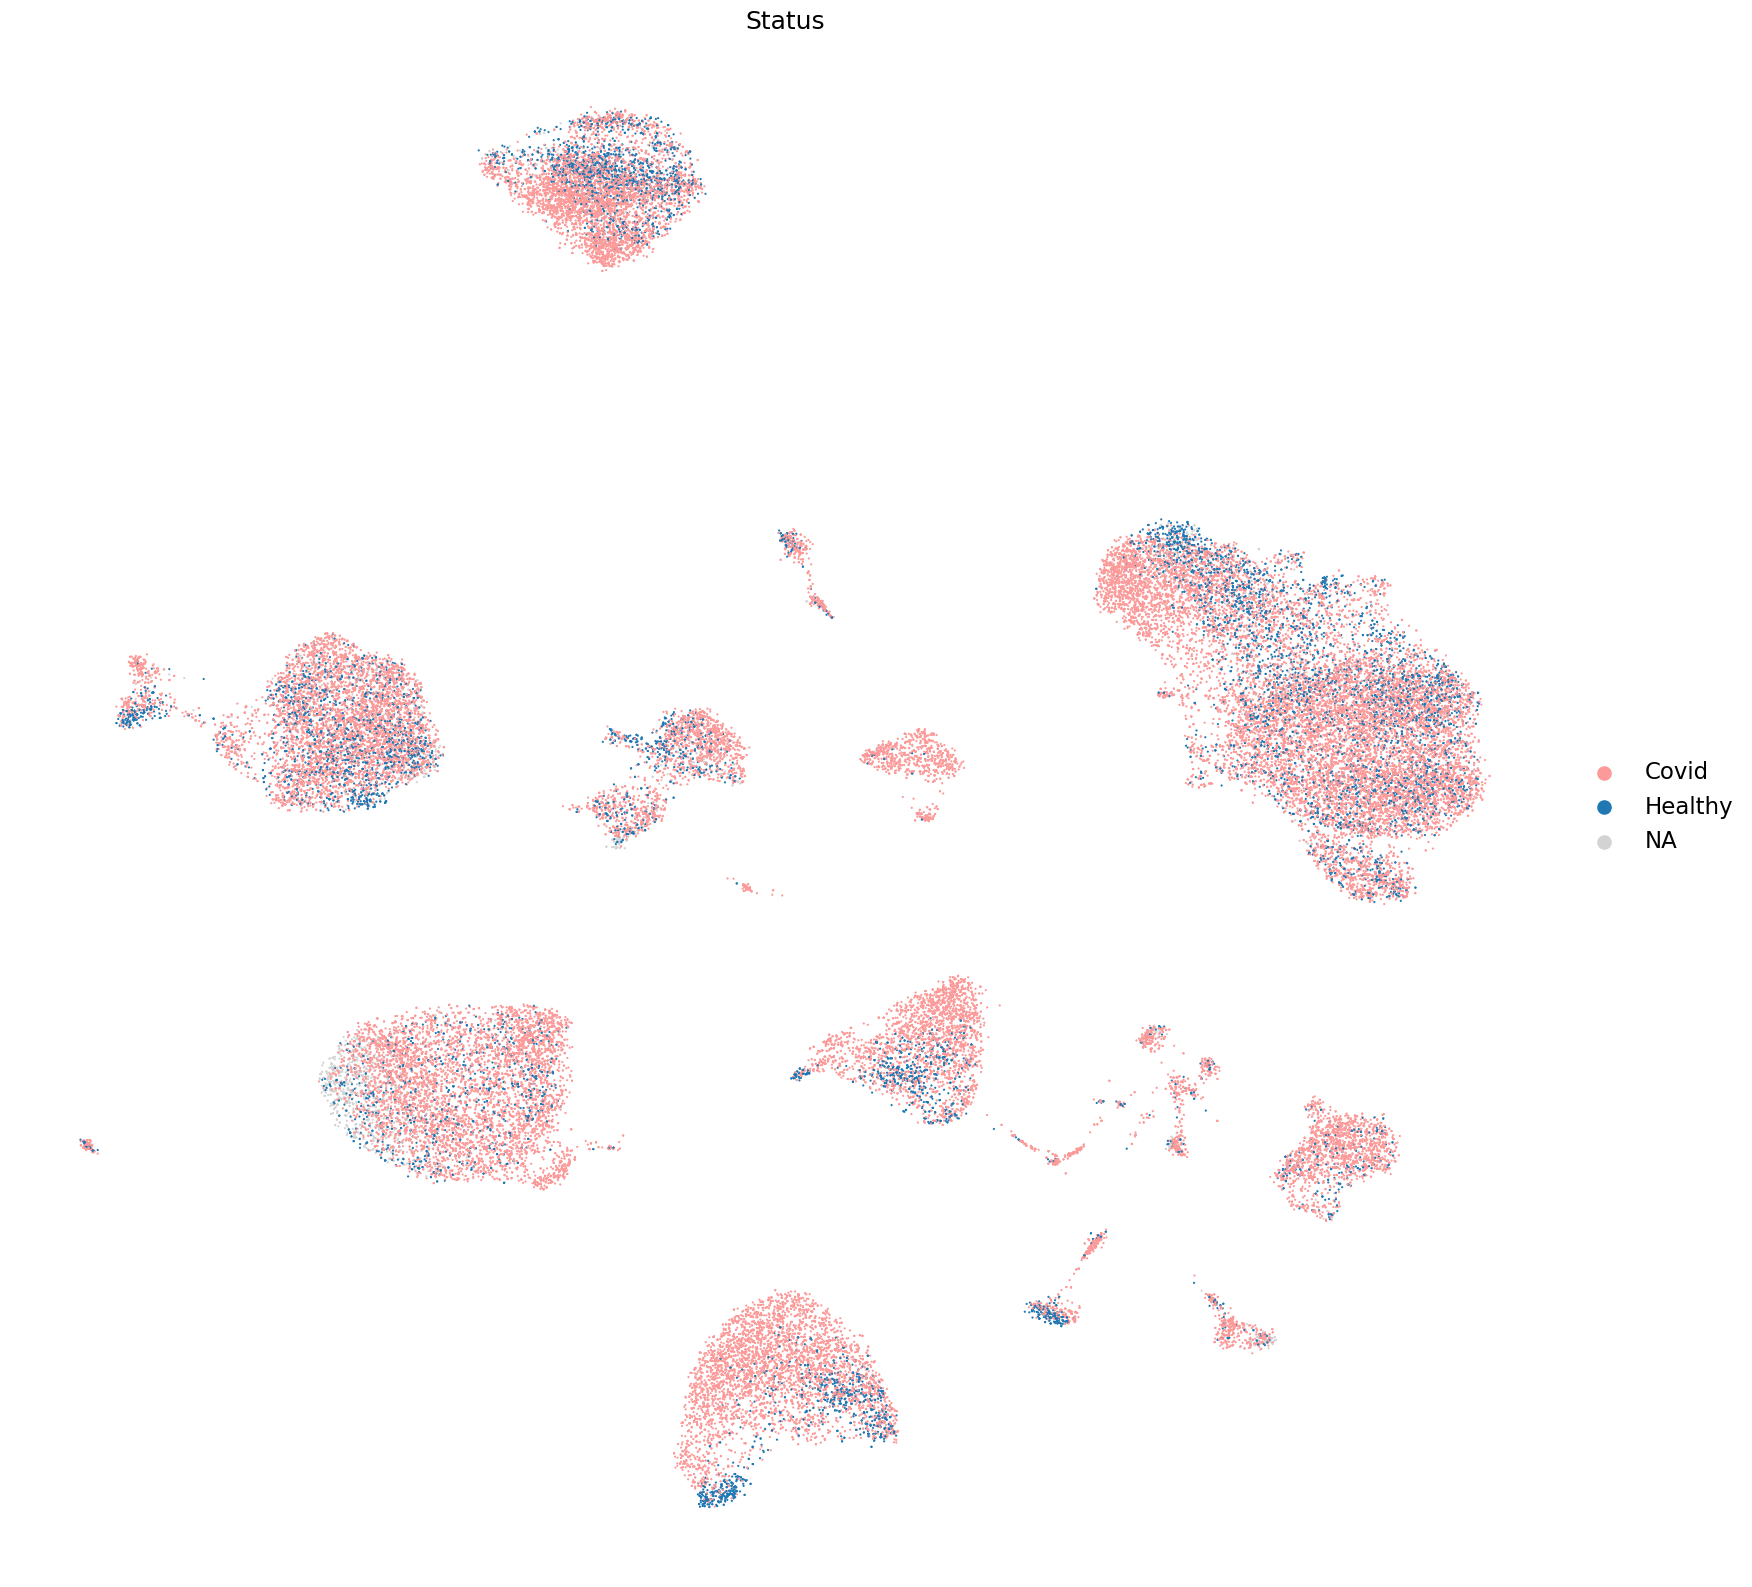

In [32]:
covid_palette = {'Covid':'#fb9a99', "Healthy":'#1f78b4', 'LPS':'#fdbf6f', 'Non_covid':'#fdbf6f'}

with rc_context({'figure.figsize':[20,20]}):
    sc.pl.umap(adata_design[np.random.choice(adata_design.obs_names, adata_design.n_obs)], color=['Status'], 
               legend_loc='right margin', frameon=False, groups=['Covid', 'Healthy'],
               size=10, palette=covid_palette,
              save='PC_covid_status.pdf');

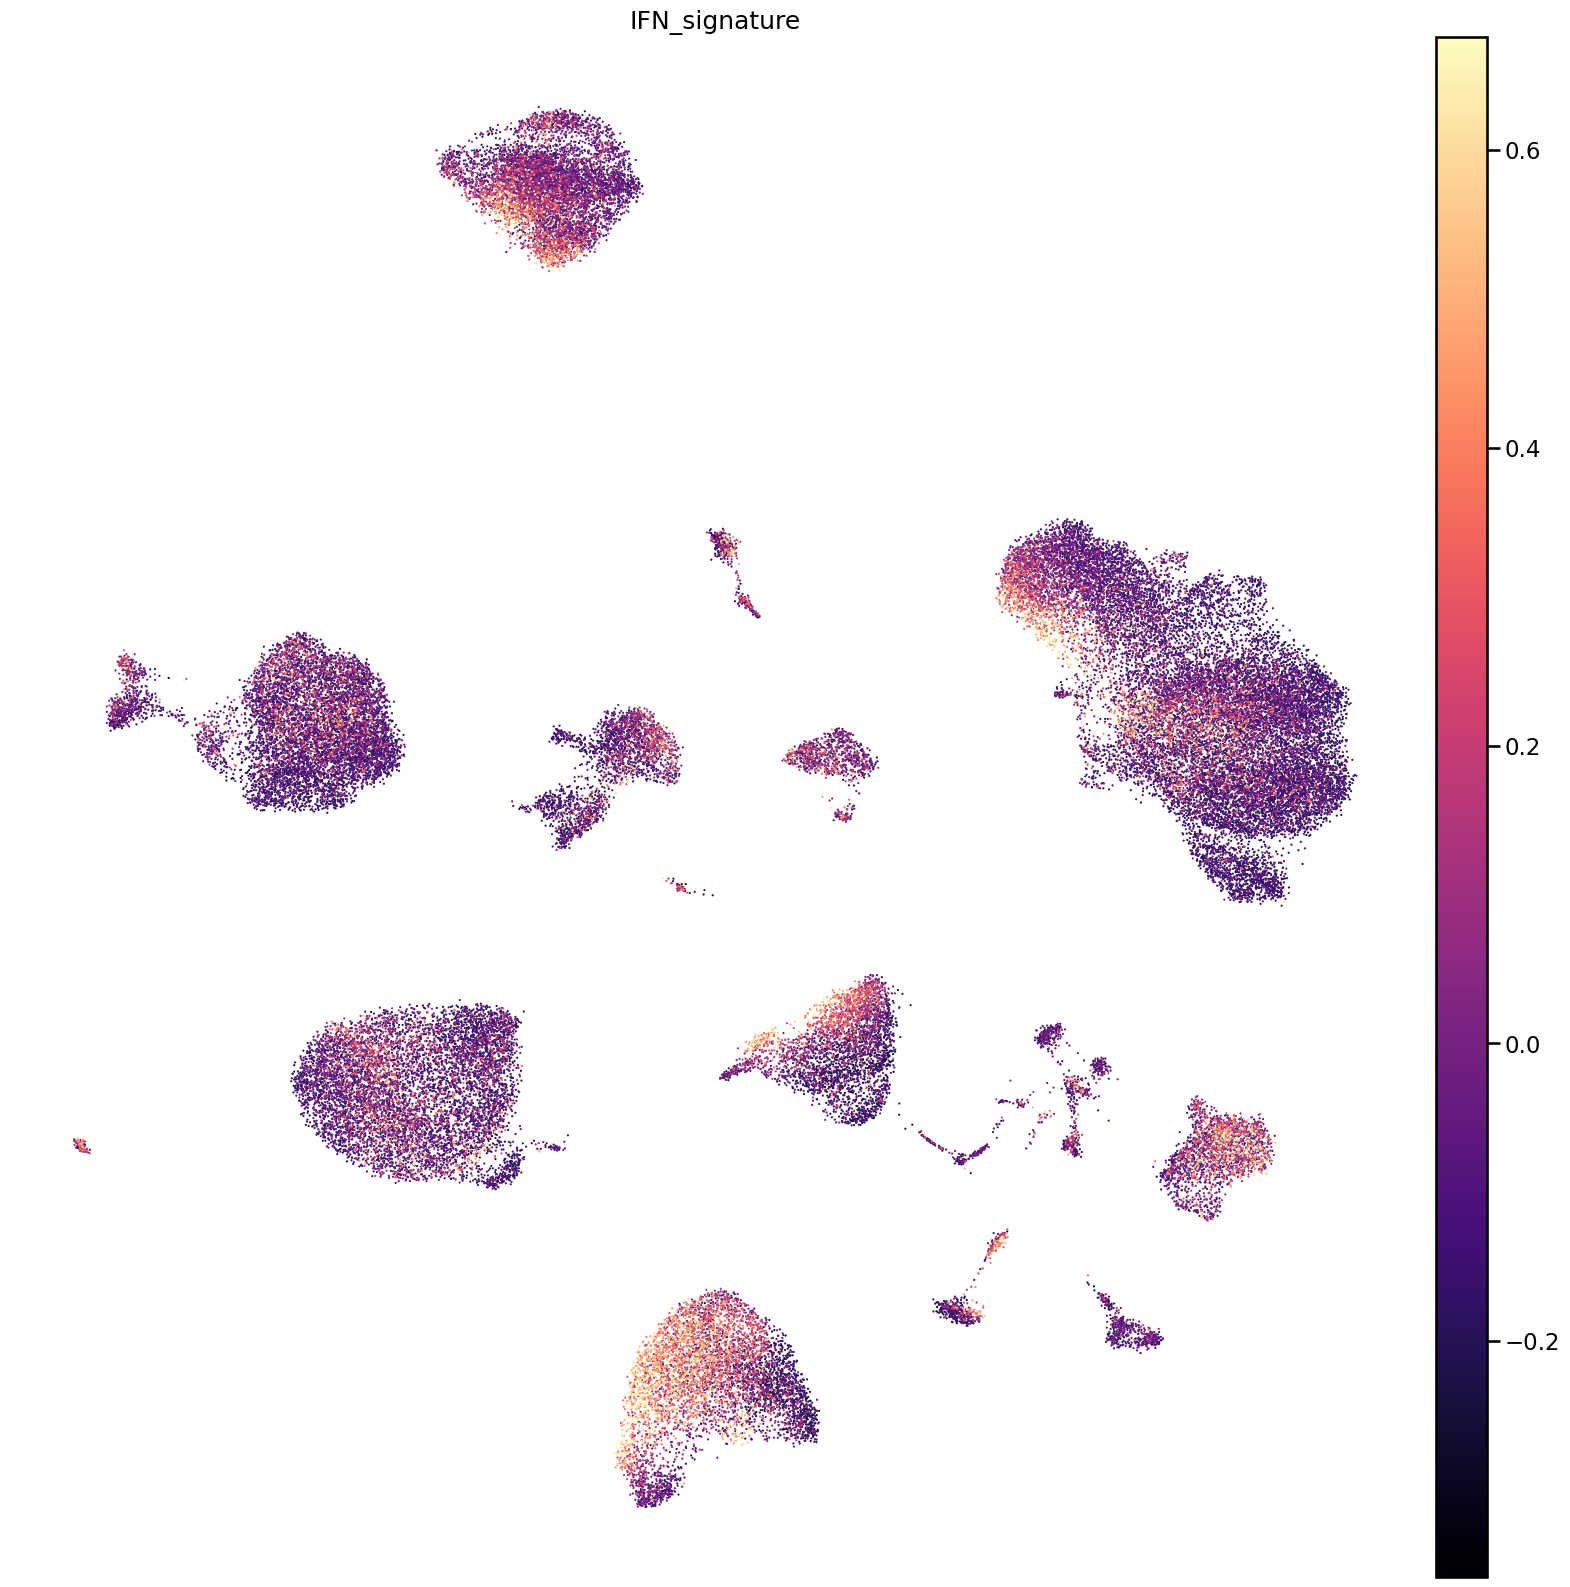

In [33]:
covid_palette = {'Covid':'#fb9a99', "Healthy":'#1f78b4', 'LPS':'#fdbf6f'}
with rc_context({'figure.figsize':[20,20]}):
    sc.pl.umap(adata_design, color=['IFN_signature'], 
               legend_loc='right margin', frameon=False, 
               size=10, cmap = 'magma', vmax=np.quantile(adata_design.obs['IFN_signature'], 0.99),
              save='PC_IFN_status.pdf');

## Plot IFN state recovery

In [23]:
adata_CR = sc.read_h5ad("/nfs/public/chenyx/OOR/data/PBMC_COVID.subsample500cells.design.query_P_refC.post_milo.h5ad")
adata_ACR = sc.read_h5ad("/nfs/public/chenyx/OOR/data/PBMC_COVID.subsample500cells.design.query_PC_refA.post_milo.h5ad")

adata_CR.uns['nhood_adata'] = sc.read_h5ad("/nfs/public/chenyx/OOR/data/PBMC_COVID.subsample500cells.design.query_P_refC.post_milo.nhood_adata.h5ad")
adata_ACR.uns['nhood_adata'] = sc.read_h5ad("/nfs/public/chenyx/OOR/data/PBMC_COVID.subsample500cells.design.query_PC_refA.post_milo.nhood_adata.h5ad")

adata_ACR.obs['author_cell_type_broad'] = [anno_labels_dict[x] for x in adata_ACR.obs['author_cell_type']]

In [24]:
milopy.utils.annotate_nhoods(adata_CR, 'author_cell_type_broad')
milopy.utils.annotate_nhoods(adata_ACR, 'author_cell_type_broad')

In [25]:
milopy.utils.annotate_nhoods(adata_design, 'author_cell_type_broad')

In [26]:
nhood_adata = adata_design.uns['nhood_adata'].copy()
nhood_adata_acr = adata_ACR.uns['nhood_adata'].copy()
nhood_adata_cr = adata_CR.uns['nhood_adata'].copy()

pl_cell_types = nhood_adata.obs['nhood_annotation'].value_counts().index
pl_cell_types = pl_cell_types[pl_cell_types != 'nan']

In [27]:
df1 = nhood_adata_acr.obs[['nhood_IFN_signature', 'logFC', "SpatialFDR", 'nhood_annotation']]
df1['design'] = 'ACR'
df2 = nhood_adata_cr.obs[['nhood_IFN_signature', 'logFC', "SpatialFDR", 'nhood_annotation']]
df2['design'] = 'CR'
df3 = nhood_adata.obs[['nhood_IFN_signature', 'logFC', "SpatialFDR", 'nhood_annotation']]
df3['design'] = 'CR scMulan'

/tmp/ipykernel_1028640/243373906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['design'] = 'ACR'
/tmp/ipykernel_1028640/243373906.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['design'] = 'CR'
/tmp/ipykernel_1028640/243373906.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [28]:
pl_df = pd.concat([df1, df2, df3])

In [29]:
%%R -i pl_df
head(pl_df)

  nhood_IFN_signature      logFC

/data/chenyx/anaconda3/envs/oor-benchmark-env/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


  SpatialFDR nhood_annotation design
1         -0.00220008 -0.2194488 0.773792012          NK_16hi    ACR
2         -0.06581493 -0.5853851 0.271597767            CD8_T    ACR
3         -0.07545920 -0.2437837 0.751638382           B_cell    ACR
4         -0.06753626  0.2168581 0.777359813            CD4_T    ACR
5         -0.14077664 -0.2466057 0.766543201            CD4_T    ACR
6         -0.02367600 -1.4926319 0.005747825            CD4_T    ACR


In [45]:
%%R -w 1200 -h 400 -i figdir
pl_df %>%
    group_by(nhood_annotation, design) %>%
    ggplot(aes(x=logFC, y=nhood_IFN_signature)) +
    #rasterise(geom_point(size=0.2, alpha=0.7)) +
    geom_point(size=0.2, alpha=0.7) +
    #rasterise(geom_point(data = . %>% filter(SpatialFDR < 0.1 & logFC > 0), aes(color='SpatialFDR < 0.1'), size=0.5, alpha=0.9)) +
    geom_point(data = . %>% filter(SpatialFDR < 0.1 & logFC > 0), aes(color='SpatialFDR < 0.1'), size=0.5, alpha=0.9) +
    facet_wrap(design~., labeller='label_both') +
    guides(color=guide_legend(title='', override.aes = list(size=2))) +
    theme_bw(base_size=24) +
    geom_vline(xintercept=0, linetype=2) +
    geom_hline(yintercept=0.05, linetype='dashed', color='red') +
    xlab("DA logFC") + ylab("IFN signature") +
    theme(legend.position='top') +
    ggpubr::stat_cor(size=6)
ggsave(paste0(figdir, 'IFNVSlogFC_all_ggplot.pdf'), width=18, height=9) 

In [30]:
%%R
library(cocor)

In [31]:
pl_df2 = pd.concat([df1, df3])
pl_df3 = pd.concat([df2, df3])

In [32]:
%%R -i pl_df2
cocor_res <- cocor(formula = ~ logFC + nhood_IFN_signature | logFC + nhood_IFN_signature, 
      data = split(pl_df2, pl_df2$design))
cocor_res


  Results of a comparison of two correlations based on independent groups

Comparison between r1.jk (logFC, nhood_IFN_signature) = 0.6346 and r2.hm (logFC, nhood_IFN_signature) = 0.7495
Difference: r1.jk - r2.hm = -0.1149
Data: ACR: j = logFC, k = nhood_IFN_signature; CR scMulan: h = logFC, m = nhood_IFN_signature
Group sizes: n1 = 4789, n2 = 2948
Null hypothesis: r1.jk is equal to r2.hm
Alternative hypothesis: r1.jk is not equal to r2.hm (two-sided)
Alpha: 0.05

fisher1925: Fisher's z (1925)
  z = -9.5114, p-value = 0.0000
  Null hypothesis rejected

zou2007: Zou's (2007) confidence interval
  95% confidence interval for r1.jk - r2.hm: -0.1380 -0.0917
  Null hypothesis rejected (Interval does not include 0)



/data/chenyx/anaconda3/envs/oor-benchmark-env/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [33]:
%%R  -i pl_df3
cocor_res <- cocor(formula = ~ logFC + nhood_IFN_signature | logFC + nhood_IFN_signature, 
      data = split(pl_df3, pl_df3$design))
cocor_res


  Results of a comparison of two correlations based on independent groups

Comparison between r1.jk (logFC, nhood_IFN_signature) = 0.5097 and r2.hm (logFC, nhood_IFN_signature) = 0.7495
Difference: r1.jk - r2.hm = -0.2398
Data: CR: j = logFC, k = nhood_IFN_signature; CR scMulan: h = logFC, m = nhood_IFN_signature
Group sizes: n1 = 4846, n2 = 2948
Null hypothesis: r1.jk is equal to r2.hm
Alternative hypothesis: r1.jk is not equal to r2.hm (two-sided)
Alpha: 0.05

fisher1925: Fisher's z (1925)
  z = -17.5232, p-value = 0.0000
  Null hypothesis rejected

zou2007: Zou's (2007) confidence interval
  95% confidence interval for r1.jk - r2.hm: -0.2660 -0.2136
  Null hypothesis rejected (Interval does not include 0)



In [39]:
%%R -w 900 -h 3000
pl_df %>%
# group_by(nhood_annotation, design) %>%
# mutate(n_DA = sum(logFC > 1))  %>%
# ungroup() %>%
# filter(n_DA > 5) %>%
ggplot(aes(x=logFC, y=nhood_IFN_signature)) +
geom_point(size=0.3, alpha=0.9) +
geom_point(data = . %>% filter(SpatialFDR < 0.1 & logFC > 0), aes(color='SpatialFDR < 0.1'), size=0.5, alpha=0.9) +
facet_grid(nhood_annotation~design, labeller=labeller(design=label_both)) +
guides(color=guide_legend(title='', override.aes = list(size=2))) +
theme_bw(base_size=24) +
geom_vline(xintercept=0, linetype=2) +
geom_hline(yintercept=0.05, linetype='dashed', color='red') +
xlab("DA logFC") + ylab("IFN signature") +
theme(legend.position='top')
ggsave(paste0(figdir, 'IFNVSlogFC_cts_ggplot.png'), width=12, height=32)

In [35]:
%%R -w 900 -h 1000 -o pl_df
pl_df <- pl_df %>%
    mutate(nhood_annotation = ifelse(str_detect(nhood_annotation, 'NK'), 'NK', nhood_annotation)) %>%
    filter(nhood_annotation %in% c('B_cell', 'NK', 'CD4_T', 'CD8_T')) %>%
    group_by(nhood_annotation, design) %>%
    mutate(thresh_quant = quantile(nhood_IFN_signature, 0.90)) %>%
    mutate(is_IFN_activates = nhood_IFN_signature > thresh_quant)

pl_df %>%
ggplot(aes(x=logFC, y=nhood_IFN_signature)) +
geom_point(size=0.3, alpha=0.9) +
geom_point(data = . %>% filter(SpatialFDR < 0.1 & logFC > 0), aes(color='SpatialFDR < 0.1'), size=1, alpha=0.9) +
facet_grid(nhood_annotation~design, labeller=labeller(design=label_both), scales='free_y') +
guides(color=guide_legend(title='', override.aes = list(size=2))) +
theme_bw(base_size=24) +
geom_vline(xintercept=0, linetype=2) +
geom_hline(aes(yintercept=thresh_quant), linetype='dashed', color='red') +
xlab("DA logFC") + ylab("IFN signature") +
theme(legend.position='top')+
ggpubr::stat_cor()
ggsave(paste0(figdir, 'scatter_lymphocytes.pdf'))   

Saving 12.5 x 13.9 in image


In [41]:
from oor_benchmark.metrics import auprc

auprc_df = pd.DataFrame()
for design in ['CR', "ACR", "CR scMulan"]:
    for ct in pl_df.nhood_annotation.unique():
        nh_df = pl_df[(pl_df['design'] == design) & (pl_df.nhood_annotation == ct)]
        nh_df['OOR_state_group'] = nh_df['is_IFN_activates'].copy()
        nh_df['OOR_score'] = nh_df['logFC'].copy()
        auprc_df_ct = auprc.auprc(nh_df, return_curve=True)
        auprc_df_ct['design'] = design
        auprc_df_ct['thresh'] = nh_df['is_IFN_activates'].sum()/nhood_adata_cr.n_obs
        auprc_df_ct['nhood_annotation'] = ct
        auprc_df = pd.concat([auprc_df, auprc_df_ct])

/tmp/ipykernel_1961976/2266999826.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_state_group'] = nh_df['is_IFN_activates'].copy()
/tmp/ipykernel_1961976/2266999826.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_score'] = nh_df['logFC'].copy()
/tmp/ipykernel_1961976/2266999826.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [42]:
df = auprc_df[['AUPRC', 'design','thresh', 'nhood_annotation']].drop_duplicates()

In [43]:
%%R -i df
df %>%
mutate(design = ifelse(design == 'CR', 'joint_CR', design)) %>%
ggplot(aes(AUPRC, nhood_annotation, fill=design)) +
geom_col(position='dodge') +
#geom_errorbarh(position=position_dodge(width=0.9), aes(xmin=CI_lower,xmax=CI_upper), height=0.1) +
theme_bw(base_size=24) +
scale_fill_manual(values=design_palette) +
ylab("AUPRC\n(top 10% IFN signature)") +
geom_vline(xintercept=0.1, linetype=2, size=1)
ggsave(paste0(figdir, 'AUPRC_lymphocytes.pdf'))

Saving 6.67 x 6.67 in image


/data/chenyx/anaconda3/envs/oor-benchmark-env/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In addition: Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


### Check IFN-low positives

In [243]:
adata_design

AnnData object with n_obs × n_vars = 62509 × 24727
    obs: 'n_genes', 'total_counts_mt', 'pct_counts_mt', 'initial_clustering', 'Resample', 'Collection_Day', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'dataset_group', 'IF

In [244]:
order_cts_acr = nhood_adata_acr.obs.groupby('nhood_annotation')['nhood_IFN_signature'].mean().sort_values().index
order_cts_cr = nhood_adata_cr.obs.groupby('nhood_annotation')['nhood_IFN_signature'].mean().sort_values().index
order_cts_mulan = nhood_adata.obs.groupby('nhood_annotation')['nhood_IFN_signature'].mean().sort_values().index

mki67_id = adata_ACR.var[adata_ACR.var_names == 'MKI67']['gene_id'].astype('str')[0]
adata_CR.obs['MKI67_expression'] = adata_CR[:, mki67_id].X.toarray()
milopy.utils.annotate_nhoods_continuous(adata_CR, 'MKI67_expression')
adata_ACR.obs['MKI67_expression'] = adata_ACR[:, 'MKI67'].X.toarray()
milopy.utils.annotate_nhoods_continuous(adata_ACR, 'MKI67_expression')
adata_design.obs['MKI67_expression'] = adata_design[:, mki67_id].X.toarray()
milopy.utils.annotate_nhoods_continuous(adata_design, 'MKI67_expression')

nhood_acr_df = adata_ACR.uns['nhood_adata'].obs.copy()
nhood_acr_df['design'] = 'ACR'
nhood_cr_df = adata_CR.uns['nhood_adata'].obs.copy()
nhood_cr_df['design'] = 'CR'
nhood_mulan_df = adata_design.uns['nhood_adata'].obs.copy()
nhood_mulan_df['design'] = 'CR scMulan'
nhood_df = pd.concat([nhood_acr_df, nhood_cr_df, nhood_mulan_df])

In [245]:
%%R -i nhood_df
unique(nhood_df$design)

/data/chenyx/anaconda3/envs/oor-benchmark-env/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


[1] "ACR"        "CR"         "CR scMulan"


In [246]:
%%R 
nhood_df %>%
filter(nhood_annotation %in% c("CD4_T", "CD8_T", 'B_cell')) %>%
# filter(design == 'CR') %>%
ggplot(aes(logFC, nhood_MKI67_expression)) +
    geom_point(size=0.4, alpha=0.7) +
    geom_point(data = . %>% filter(SpatialFDR < 0.1 & logFC > 0), aes(color='SpatialFDR < 0.1'), size=0.8, alpha=0.9) +
    facet_grid(design~nhood_annotation) +
    guides(color=guide_legend(title='', override.aes = list(size=2))) +
    theme_bw(base_size=24) +
    geom_vline(xintercept=0, linetype=2) +
    xlab("DA logFC") + ylab("mean MKI67 expression") +
    theme(legend.position='top')
ggsave(paste0(figdir, 'CR_MKI67VSlogFC_all_ggplot.png'), width=12, height=8)

In [247]:
milopy.utils.annotate_nhoods(adata_design, 'author_cell_type')
milopy.utils.annotate_nhoods(adata_CR, 'author_cell_type')
milopy.utils.annotate_nhoods(adata_ACR, 'author_cell_type')

In [249]:
nhood_df_acr = adata_ACR.uns['nhood_adata'].obs.copy()
nhood_df_cr = adata_CR.uns['nhood_adata'].obs.copy()
nhood_df_mulan = adata_design.uns['nhood_adata'].obs.copy()


nhood_df_acr['design'] = "ACR"
nhood_df_cr['design'] = "CR"
nhood_df_mulan['design'] = "CR scMulan"
nh_df = pd.concat([nhood_df_cr, nhood_df_acr, nhood_df_mulan])

In [250]:
%%R -i nh_df
head(nh_df)

/data/chenyx/anaconda3/envs/oor-benchmark-env/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


                                            index_cell kth_distance
1 10_1038_s41591_021_01329_2-BGCV01_TGGGCGTGTCGCTTTC-1     1.565102
2 10_1038_s41591_021_01329_2-BGCV01_TAGTTGGGTATGCTTG-1     1.403343
3 10_1038_s41591_021_01329_2-BGCV01_ATGGGAGTCCCATTTA-1     1.355805
4 10_1038_s41591_021_01329_2-BGCV01_ACGCCGAGTGAAATCA-1     1.285266
5 10_1038_s41591_021_01329_2-BGCV01_GTCATTTTCGCTGATA-1     1.357077
6 10_1038_s41591_021_01329_2-BGCV01_GATTCAGAGGGTTCCC-1     1.265132
  nhood_annotation nhood_annotation_frac       logFC   logCPM           F
1          NK_16hi             0.4705882 -1.69037556 8.847513 23.53994743
2          NK_16hi             0.9225352  0.06809853 8.810621  0.03176861
3           CD4.CM             0.3903743 -0.51238337 8.963314  1.73598730
4          NK_16hi             0.9121951 -0.57317392 8.997533  2.49774128
5          NK_16hi             0.9757575 -0.41248521 8.889545  1.27260129
6          B_naive             0.8791946 -0.27122638 8.806710  0.51189149
      

In [252]:
%%R -h 700 -w 900
nh_df %>%
filter(nhood_annotation_frac > 0.5) %>%
mutate(signif=ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
group_by(nhood_annotation)%>%
mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
mutate(mean_lfc = mean(mean_lfc_val)) %>%
ungroup() %>%
arrange(mean_lfc) %>%
mutate(nhood_annotation=factor(nhood_annotation, levels=unique(nhood_annotation))) %>%
ggplot(aes(nhood_annotation, logFC, color=signif)) + 
    ggbeeswarm::geom_quasirandom(size=0.5) +
        coord_flip() +
        facet_wrap(design~.) +
        scale_color_gradient2(high='red', mid='grey', low='blue', name='DA logFC\n(10% SpatialFDR)') +
        theme_bw(base_size=18) +
        geom_hline(yintercept=0, linetype=2) +
        xlab('Nhood annotation\n(original fine annotation)') + xlab('DA logFC')
ggsave(paste0(figdir, 'beeswarm_fine_anno.png'), width=15, height=12)

In [253]:
%%R -h 700 -w 600 -i nh_df
p1 <- nh_df %>%
filter(nhood_annotation_frac > 0.5) %>%
# filter(logFC > 0 & SpatialFDR < 0.1) %>%
filter(design == 'CR') %>%
mutate(signif=ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
group_by(nhood_annotation)%>%
mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
mutate(mean_lfc = max(mean_lfc_val)) %>%
ungroup() %>%
arrange(mean_lfc) %>%
mutate(nhood_annotation=factor(nhood_annotation, levels=unique(nhood_annotation))) %>%
    mutate(signif = ifelse(logFC > 4, 4, ifelse(signif < -2.1, -2.1, signif))) %>%
ggplot(aes(nhood_annotation, logFC, color=signif)) + 
    ggbeeswarm::geom_quasirandom(size=0.5) +
        coord_flip() +
        facet_wrap(design~.) +
        scale_color_gradient2(high='red', mid='grey', low='blue', name='DA logFC\n(10% SpatialFDR)') +
        theme_bw(base_size=18) +
        geom_hline(yintercept=0, linetype=2) +
        xlab('Nhood annotation\n(original fine annotation)') + xlab('DA logFC')

In [254]:
%%R -h 700 -w 600 -i nh_df
p2 <- nh_df %>%
    filter(nhood_annotation_frac > 0.5) %>%
    # filter(logFC > 0 & SpatialFDR < 0.1) %>%
    filter(design == 'ACR') %>%
    mutate(signif=ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
    group_by(nhood_annotation)%>%
    mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
    mutate(mean_lfc = max(mean_lfc_val)) %>%
    ungroup() %>%
    arrange(mean_lfc) %>%
    mutate(nhood_annotation=factor(nhood_annotation, levels=unique(nhood_annotation))) %>%
    mutate(signif = ifelse(signif > 4, 4, ifelse(signif < -2.1, -2.1, signif))) %>%
    ggplot(aes(nhood_annotation, logFC, color=signif)) + 
        ggbeeswarm::geom_quasirandom(size=0.5) +
            coord_flip() +
            facet_wrap(design~.) +
            scale_color_gradient2(high='red', mid='grey', low='blue', name='DA logFC\n(10% SpatialFDR)') +
            theme_bw(base_size=18) +
            geom_hline(yintercept=0, linetype=2) +
            xlab('Nhood annotation\n(original fine annotation)') + xlab('DA logFC')

In [255]:
%%R -h 700 -w 600 -i nh_df
p3 <- nh_df %>%
filter(nhood_annotation_frac > 0.5) %>%
# filter(logFC > 0 & SpatialFDR < 0.1) %>%
filter(design == 'CR scMulan') %>%
mutate(signif=ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
group_by(nhood_annotation)%>%
mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
mutate(mean_lfc = max(mean_lfc_val)) %>%
ungroup() %>%
arrange(mean_lfc) %>%
mutate(nhood_annotation=factor(nhood_annotation, levels=unique(nhood_annotation))) %>%
    mutate(signif = ifelse(logFC > 4, 4, ifelse(signif < -2.1, -2.1, signif))) %>%
ggplot(aes(nhood_annotation, logFC, color=signif)) + 
    ggbeeswarm::geom_quasirandom(size=0.5) +
        coord_flip() +
        facet_wrap(design~.) +
        scale_color_gradient2(high='red', mid='grey', low='blue', name='DA logFC\n(10% SpatialFDR)') +
        theme_bw(base_size=18) +
        geom_hline(yintercept=0, linetype=2) +
        xlab('Nhood annotation\n(original fine annotation)') + xlab('DA logFC')

In [256]:
%%R

(p3 + p2 + p1) + 
plot_layout(guides='collect')
ggsave(paste0(figdir, 'beeswarm_fine_anno.png'), width=14, height=12) 

## IFN-low enriched states - CD14+ monocyte subtypes

In [265]:
adata = adata_design.copy()

In [266]:
anno_labels = adata.obs['author_cell_type'].unique()
anno_groups = {}
anno_groups['B_cell'] = [x for x in adata.obs['author_cell_type'].unique() if x.startswith('B_')]
anno_groups['HSPC'] = [x for x in adata.obs['author_cell_type'].unique() if x.startswith('HSC_')]
anno_groups['CD14_mono'] =[x for x in adata.obs['author_cell_type'].unique() if 'CD14_mono' in x]
anno_groups['CD16_mono'] =[x for x in adata.obs['author_cell_type'].unique() if 'CD16_mono' in x]
anno_groups['CD4_T'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("CD4.")]
anno_groups['CD8_T'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("CD8.")]
anno_groups['ILC'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("ILC")]
anno_groups['Plasma_cell'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("Plasma_cell")]

for x in anno_labels: 
    if x not in sum(anno_groups.values(), []):
        anno_groups[x] = [x]

anno_labels_dict = {x:k for k,v in anno_groups.items() for x in v}
adata.obs['author_cell_type_broad'] = [anno_labels_dict[x] for x in adata.obs['author_cell_type']]
milopy.utils.annotate_nhoods(adata, anno_col='author_cell_type_broad')

In [267]:
milo_res = adata.uns['nhood_adata'].obs.copy()

In [268]:
mono_res=milo_res[milo_res.nhood_annotation.isin(['CD14_mono', 'CD16_mono'])]

In [269]:
%%R -i mono_res
head(mono_res)

                                              index_cell kth_distance
79  10_1038_s41591_021_01329_2-BGCV05_GCTTCCATCGTCACGG-1     4.884855
85  10_1038_s41591_021_01329_2-BGCV05_TCAATCTTCTAACTCT-1     5.047904
106 10_1038_s41591_021_01329_2-BGCV08_TAGGCATTCTAACCGA-1     4.396280
119 10_1038_s41591_021_01329_2-BGCV08_GGATTACGTGAGGCTA-1     4.691374
127 10_1038_s41591_021_01329_2-BGCV08_ATAAGAGAGTCACGCC-1     4.771845
177 10_1038_s41591_021_01329_2-BGCV10_CCAATCCCATTTGCTT-1     4.864165
    nhood_annotation nhood_annotation_frac      logFC   logCPM         F
79         CD14_mono             0.9119496 -0.7207067 8.925339  2.452355
85         CD14_mono             0.9999999 -1.8526052 8.902530 22.265373
106        CD14_mono             0.9949238 -0.4449064 9.498580  1.141062
119        CD14_mono             0.9949495 -1.2067925 8.975416  9.936538
127        CD14_mono             0.9906833 -0.7942905 9.380075  3.626628
177        CD14_mono             1.0000000 -1.1508204 9.227677  8.171991

In [270]:
%%R
mono_res %>%
    filter(nhood_annotation == 'CD14_mono') %>%
    ggplot(aes(logFC, nhood_IFN_signature)) +
    geom_point(size=0.7, shape=21) +
    geom_point(data=. %>% filter(SpatialFDR < 0.1 & logFC > 1 & nhood_IFN_signature > 0.2), 
               shape=21,
               aes(fill='IFN-high COVID nhoods')) +
    geom_point(data=. %>% filter(SpatialFDR < 0.1 & logFC > 1 & nhood_IFN_signature < 0.2), 
               shape=21,
               aes(fill='IFN-low COVID nhoods')) +
    facet_wrap(nhood_annotation~.) +
    guides(fill=guide_legend(title='', override.aes = list(size=2), ncol=1)) +
    theme_bw(base_size=24) +
    scale_fill_brewer(palette='Spectral', name='') +
    geom_vline(xintercept=0, linetype=2) +
#     geom_hline(yintercept=0, linetype='dashed', color='red') +
    xlab("DA logFC") + ylab("IFN signature") +
    theme(legend.position='top')
ggsave(paste0(figdir, 'groups_CD14_monos.png'), height=7, width=7) 

In [303]:
import diff2atlas

def run_glmGamPoi_DE(pbulk_adata, 
                     design = '~ Site + nhood_groups',
                    ref_level = 'in_nhoods_other',
                    contrast = 'nhood_groupsin_nhoods_critical',
                     n_hvgs = 5000):
    '''
    Run R code for DE analysis with glmGamPoi
    
    Params:
    ------
    - pbulk_adata: anndata object with pseudobulked data
    
    '''
    
    ## Define R function
    glmgampoi_str = f'''
        library(SingleCellExperiment)
        library(glmGamPoi)
        library(scran)
        library(scater)

        run_de <- function(args){{
            pbulk_sdata_X <- args[[1]]
            pbulk_sdata_obs <- args[[2]]
            pbulk_sdata_var <- args[[3]]
            n_hvgs <- args[[4]]

            sce <- SingleCellExperiment(assays = list(counts = t(pbulk_sdata_X)), colData = pbulk_sdata_obs)
            sce <- logNormCounts(sce)

            ## Feature selection w scran (just on test cell types)
            dec <- modelGeneVar(sce)
            hvgs <- getTopHVGs(dec, n = n_hvgs)
            subset_sce <- sce[hvgs,]

            ## Fit
            fit <- glm_gp(subset_sce, design = {design}, reference_level = '{ref_level}')

            ## Test 
            de_res <- test_de(fit, contrast = '{contrast}')    
            de_res[,'gene_name'] <- pbulk_sdata_var[hvgs,]['gene_name']
            return(de_res)
        }}'''
    
    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP
    
    ## Get anndata components
    pbulk_sdata_X = pbulk_adata.X.toarray().copy()
    pbulk_sdata_obs = pbulk_adata.obs.copy()
    pbulk_sdata_var = pbulk_adata.var.copy()
    
    r_pkg = STAP(glmgampoi_str, "r_pkg")
    # this was needed for the code to run on jhub
    # if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    args = [pbulk_sdata_X, pbulk_sdata_obs, pbulk_sdata_var, n_hvgs]
    de_res_df = r_pkg.run_de(args).to_csvfile('./DE_results.csv')
    de_res_df = pd.read_csv('./DE_results.csv', index_col=0)
    de_res_df.index = de_res_df['gene_name']
    de_res_df.drop('name',  axis=1, inplace=True)
    os.remove('./DE_results.csv')
    return(de_res_df)

def find_nhood_group_markers(
    adata, 
    test_group: str,
    ctrl_group: str,
    confounders_obs = None,
    nhood_group_obs: str = 'nhood_groups',
    min_n_nhoods: int = 3,
    pbulk_use_layer: str = None,
    n_hvgs: int = 5
    ):
    '''
    Find genes differentially expressed between cells in 2 groups of neighbourhoods
    
    Params:
    -------
    - adata: AnnData object storing nhood info in adata.uns['nhood_adata']
    - design: design formula for the test, passed to glmGamPoi
    - test_group: which neighbourhood group is the test group?
    - ctrl_group: which neighbourhood group is the reference group?
    - nhood_group_obs: the column in adata.uns['nhood_adata'] storing the neighbourhood group information
    - min_n_nhoods: cells are assigned to a neighbourhood group only if it belongs to at least min_n_nhoods neighbourhoods in the group
    - pbulk_use_layer: layer storing counts (if None, adata.X is used) 
    - n_hvgs: how many HVGS to use for the DE test (the more you use, the longer it takes)
    
    Returns:
    --------
    pd.DataFrame storing DE test results
    '''

    ## Find cells in nhoods of interest
    groups = adata.uns['nhood_adata'].obs[nhood_group_obs].dropna().unique()
    for g in groups:
        nhoods_oi = adata.uns['nhood_adata'].obs_names[adata.uns['nhood_adata'].obs[nhood_group_obs] == g]
        diff2atlas.utils.get_cells_in_nhoods(adata, nhoods_oi)
        adata.obs[f'in_nhoods_{g}'] = adata.obs['in_nhoods'].copy()

    ## Find most representative group (cell belongs to mostly to neighbourhoods of that group)
    adata.obs['nhood_groups'] = np.nan
    adata.obs['nhood_groups'] = adata.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
    ## Keep only if cell is in at least min_n_nhoods nhoods of the same group
    #adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan 
    column_names = [f'in_nhoods_{g}' for g in groups]  
    condition = (adata.obs[column_names] > min_n_nhoods).any(axis=1)
    adata.obs.loc[~condition, 'nhood_groups'] = np.nan 
    
    ## Make pseudobulk adata for cells if different nhood groups and samples
    sdata = adata[~adata.obs['nhood_groups'].isna()].copy()
    sdata.X = sdata.layers['counts'].copy()
    if confounders_obs is None:
        design = '~ nhood_groups'
        pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[adata.uns['nhood_adata'].uns['sample_col'], 'nhood_groups'], 
            min_ncells=1, 
            use_layer=pbulk_use_layer)
    else:
        if isinstance(confounders_obs, str):
            confounder_obs = [confounders_obs]
        design = "~ " + ' + '.join(confounders_obs) + ' + nhood_groups'
        pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[nhood_adata.uns['sample_col'], 'nhood_groups'] + confounders_obs, 
            min_ncells=1, 
            use_layer=pbulk_use_layer)
    
    pbulk_sdata.var = adata.var.copy() 
    de_results = run_glmGamPoi_DE(pbulk_sdata, design=design, 
                           ref_level = f'in_nhoods_{ctrl_group}', 
                           contrast = f'nhood_groupsin_nhoods_{test_group}', 
                           n_hvgs=n_hvgs)
    return(de_results)

In [274]:
## Select nhoods of interest
cd14_mono_res = mono_res[mono_res.nhood_annotation == 'CD14_mono']
low_ifn_monos_nhoods = cd14_mono_res.index[(cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0) & (cd14_mono_res.nhood_IFN_signature < 0.2)]
high_ifn_monos_nhoods = cd14_mono_res.index[(cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0) & (cd14_mono_res.nhood_IFN_signature > 0.2)]

In [275]:
other_monos_nhoods = cd14_mono_res.index[~((cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0))]

In [276]:
## Mark nhood groups
nhood_adata = adata.uns['nhood_adata'].copy()
nhood_adata.obs['nhood_groups'] = np.nan
nhood_adata.obs.loc[low_ifn_monos_nhoods, 'nhood_groups'] = 'low_ifn_enr'
nhood_adata.obs.loc[high_ifn_monos_nhoods, 'nhood_groups'] = 'high_ifn_enr'
nhood_adata.obs.loc[other_monos_nhoods, 'nhood_groups'] = 'other_CD14_monos'
adata.uns['nhood_adata'] = nhood_adata.copy()

In [301]:
adata = adata[:,list(adata_ACR.var.gene_id.values)]
adata.var = adata_ACR.var.copy()

/data/chenyx/anaconda3/envs/oor-benchmark-env/lib/python3.10/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['FAM87B', 'LINC00115', 'FAM41C', 'SAMD11', 'NOC2L']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [304]:
## Run DE testing
DE_monos_ifn = find_nhood_group_markers(
    adata[adata.obs['author_cell_type'] == 'CD14_mono' ], 
    test_group='low_ifn_enr', 
    ctrl_group='high_ifn_enr', 
    confounders_obs=['Site'],
    n_hvgs = 7500
    )

/home/chenyx/scMulan/cellgpt_v1/tmp_test/cyx/DA/diff2atlas/utils.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['in_nhoods'] = in_nhoods
/data/chenyx/anaconda3/envs/oor-benchmark-env/lib/python3.10/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['FAM87B', 'LINC00115', 'FAM41C', 'SAMD11', 'NOC2L']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [305]:
DE_monos_ifn

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name
gene_name,,,,,,,
IFI27,1.619404e-01,0.634109,1.969326,1,218.275171,-0.690165,IFI27
IFITM1,1.213849e-04,0.006264,15.318350,1,218.275171,-1.381987,IFITM1
IFITM3,7.558633e-05,0.004529,16.279828,1,218.275171,-0.919750,IFITM3
IFI30,1.492258e-07,0.000029,29.491268,1,218.275171,-0.533940,IFI30
S100A12,3.164542e-05,0.002100,18.064452,1,218.275171,0.723530,S100A12
...,...,...,...,...,...,...,...
IFT140,3.324030e-01,0.780682,0.943702,1,218.275171,-1.156578,IFT140
ZBTB44,8.565550e-01,0.980670,0.032752,1,218.275171,-0.052064,ZBTB44
PTGS1,3.342808e-01,0.782392,0.936383,1,218.275171,-0.381189,PTGS1


In [308]:
%%R -i DE_monos_ifn -w 800 -h 600 -i figdir
max_lfc = 15
DE_monos_ifn$lfc <- ifelse(abs(DE_monos_ifn$lfc) > max_lfc, sign(DE_monos_ifn$lfc) * Inf, DE_monos_ifn$lfc)
DE_monos_ifn %>%
#     filter(contrast == 'mild_enr-other') %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.75), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(size=0.5) +
    geom_point(data=. %>% filter(signif), color='red') +
    ggrepel::geom_text_repel(aes(label=label), color='red') +
    theme_bw(base_size=18) +
    xlab("DE log-Fold Change") +
    ylab('-log10(Adj. P-value)')
ggsave(paste0(figdir, 'volcano_CD14_monos.png'), height=7, width=7) 

In addition: Warning messages:
1: Removed 5948 rows containing missing values (`geom_text_repel()`). 
2: ggrepel: 60 unlabeled data points (too many overlaps). Consider increasing max.overlaps 


In [309]:
DE_monos_ifn.to_csv("CD14_mono.DE_results.csv")

In [312]:
import diff2atlas
def assign_cells_2_nhood_group(
    adata, 
    confounders_obs = None,
    nhood_group_obs: str = 'nhood_groups',
    min_n_nhoods: int = 3,
    pbulk_use_layer: str = None,
    ):
    '''
    
    '''
    ## Find cells in nhoods of interest
    groups = adata.uns['nhood_adata'].obs[nhood_group_obs].dropna().unique()
    for g in groups:
        nhoods_oi = adata.uns['nhood_adata'].obs_names[adata.uns['nhood_adata'].obs[nhood_group_obs] == g]
        diff2atlas.utils.get_cells_in_nhoods(adata, nhoods_oi)
        adata.obs[f'in_nhoods_{g}'] = adata.obs['in_nhoods'].copy()

    ## Find most representative group (cell belongs to mostly to neighbourhoods of that group)
    adata.obs['nhood_groups'] = np.nan
    adata.obs['nhood_groups'] = adata.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
    ## Keep only if cell is in at least min_n_nhoods nhoods of the same group
    adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(axis=1), 'nhood_groups'] = np.nan 

In [313]:
assign_cells_2_nhood_group(adata)

In [315]:
groups = adata.uns['nhood_adata'].obs['nhood_groups'].dropna().unique()
min_n_nhoods = 3
adata.obs['nhood_groups'] = np.nan
adata.obs['nhood_groups'] = adata.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
## Keep only if cell is in at least min_n_nhoods nhoods of the same group
adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(axis=1), 'nhood_groups'] = np.nan 

In [316]:
plt.rcParams['figure.figsize'] = [10, 10]
# n_cells_sev = adata.obs[['nhood_groups', 'Status_on_day_collection_summary', 'Days_from_onset', 'donor_id']].dropna().value_counts().reset_index()
# n_cells_sev['n_cells'] = n_cells_sev[0]

# n_cells_sev
# n_cells_sev = adata_c.obs[['nhood_groups', 'Status_on_day_collection_summary', 'Days_from_onset', 'donor_id']].dropna().value_counts().reset_index()
# n_cells_sev['n_cells'] = n_cells_sev[0]

# n_cells_sev
n_cells_sev = adata.obs[['nhood_groups', 'Status_on_day_collection_summary', 'donor_id']].dropna()
n_cells_sev['n_cells'] = 1
n_cells_sev = n_cells_sev.groupby(['nhood_groups', 'Status_on_day_collection_summary', 'donor_id']).sum().reset_index()

order_severity = ['Healthy', 'Asymptomatic', 'Mild', "Moderate", "Severe", "Critical"]
# sns.boxplot(data=n_cells_sev, x='Status_on_day_collection_summary', y='n_cells', hue='nhood_groups', order=order_severity)
# sns.stripplot(data=n_cells_sev, x='Status_on_day_collection_summary', y='n_cells', hue='nhood_groups', 
#               color='black', position='dodge',
#               order=order_severity)
# n_cells_sev = n_cells_sev[~n_cells_sev.Days_from_onset.isin(['Healthy', 'LPS', 'Not_known', 'nan'])]

In [317]:
%%R -i order_severity -i n_cells_sev -w 1200 -h 500
n_cells_sev %>%
    filter(Status_on_day_collection_summary %in% order_severity) %>%
    mutate(severity = factor(Status_on_day_collection_summary, levels=order_severity)) %>%
    group_by(donor_id, severity) %>%
    mutate(frac_cells = n_cells/sum(n_cells)) %>%
    ungroup() %>%
    filter(nhood_groups != 'in_nhoods_other_CD14_monos') %>%
    ggplot(aes(severity, frac_cells, fill = nhood_groups)) +
    geom_boxplot(outlier.alpha=0) +
    geom_point(position=position_jitterdodge(jitter.width=0.1)) +
#     facet_wrap(nhood_groups~.) +
#     scale_y_log10() +
    scale_fill_brewer(palette='Spectral', 
                      labels=c('in_nhoods_high_ifn_enr' = 'in IFN-high COVID nhoods', 'in_nhoods_low_ifn_enr' = 'in IFN-low COVID nhoods'),
                      name=''
                     ) +
    ylab('Fraction of\nCD14+ monocytes') +
    theme_bw(base_size=22) +
    theme(legend.position='top', legend.justification=c(1,1))
ggsave(paste0(figdir, 'CD14_monos_severity.png'), height=7, width=10)

In addition: Warning messages:
1: Removed 1204 rows containing non-finite values (`stat_boxplot()`). 
2: Removed 1204 rows containing missing values (`geom_point()`). 


Number of donors by severity

In [318]:
adata.obs[['donor_id', 'disease', 'Status_on_day_collection_summary']].drop_duplicates().value_counts('Status_on_day_collection_summary')

Status_on_day_collection_summary
Moderate        30
Healthy         23
Mild            23
Critical        15
Severe          13
Asymptomatic     9
LPS_10hours      3
LPS_90mins       3
Name: count, dtype: int64

In [319]:
%%R -i order_severity -i n_cells_sev -w 1200 -h 500 -o ttest_res 
ttest_res <- n_cells_sev %>%
    filter(Status_on_day_collection_summary %in% order_severity) %>%
    mutate(severity = factor(Status_on_day_collection_summary, levels=order_severity)) %>%
    group_by(donor_id, severity) %>%
    mutate(frac_cells = n_cells/sum(n_cells)) %>%
    ungroup() %>%
    filter(nhood_groups != 'in_nhoods_other_CD14_monos') %>%
    group_by(nhood_groups, Status_on_day_collection_summary) %>%
    summarise(fracs = list(frac_cells))  %>%
    ungroup() %>%
    pivot_wider(id_cols=nhood_groups, names_from=Status_on_day_collection_summary, values_from=fracs) %>%
        group_by(nhood_groups) %>%
    mutate(pval_vsAsymp = wilcox.test(unlist(Healthy), unlist(Asymptomatic))$p.value, stat_vsAsymp = wilcox.test(unlist(Healthy), unlist(Asymptomatic))$statistic,
          pval_vsMild = wilcox.test(unlist(Healthy), unlist(Mild))$p.value, stat_vsMild = wilcox.test(unlist(Healthy), unlist(Mild))$statistic,
          pval_vsModerate = wilcox.test(unlist(Healthy), unlist(Moderate))$p.value, stat_vsModerate = wilcox.test(unlist(Healthy), unlist(Moderate))$statistic,
          pval_vsCrit = wilcox.test(unlist(Healthy), unlist(Critical))$p.value, stat_vsCrit = wilcox.test(unlist(Healthy), unlist(Critical))$statistic,
          pval_MildvsCrit = wilcox.test(unlist(Moderate), unlist(Critical))$p.value, stat_MildvsCrit = wilcox.test(unlist(Moderate), unlist(Critical))$statistic) %>%
    select( - c(order_severity))

`summarise()` has grouped output by 'nhood_groups'. You can override using the
`.groups` argument.


In addition: Warning messages:
1: There were 20 warnings in `mutate()`.
The first warning was:
ℹ In argument: `pval_vsAsymp = wilcox.test(unlist(Healthy),
  unlist(Asymptomatic))$p.value`.
ℹ In group 1: `nhood_groups = "in_nhoods_high_ifn_enr"`.
Caused by warning in `wilcox.test.default()`:
! cannot compute exact p-value with ties
ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 remaining warnings. 
2: Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(order_severity)

  # Now:
  data %>% select(all_of(order_severity))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


In [320]:
ttest_res

,nhood_groups,pval_vsAsymp,stat_vsAsymp,pval_vsMild,stat_vsMild,pval_vsModerate,stat_vsModerate,pval_vsCrit,stat_vsCrit,pval_MildvsCrit,stat_MildvsCrit
1,in_nhoods_high_ifn_enr,0.595029,91.5,0.000450,110.0,0.000002,78.5,0.064622,113.5,0.006593,327.5
2,in_nhoods_low_ifn_enr,0.270406,77.0,0.028198,165.0,0.000021,102.5,0.000176,47.0,0.215404,167.0


/data/chenyx/anaconda3/envs/oor-benchmark-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/data/chenyx/anaconda3/envs/oor-benchmark-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


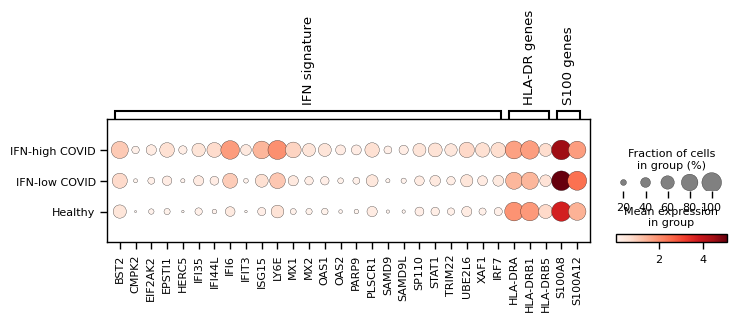

In [321]:
mono_phenotype = {
    'in_nhoods_low_ifn_enr':'IFN-low COVID',
    'in_nhoods_high_ifn_enr':'IFN-high COVID',
    'in_nhoods_other_CD14_monos':'Healthy',
    }

adata.obs['mono_phenotype'] = np.nan
adata.obs.loc[~adata.obs['nhood_groups'].isna(),'mono_phenotype'] = [mono_phenotype[x] for x in adata.obs['nhood_groups'][~adata.obs['nhood_groups'].isna()]]
adata.obs['mono_phenotype'] = adata.obs['mono_phenotype'].astype('category').cat.reorder_categories(['IFN-high COVID', 'IFN-low COVID','Healthy'])
sns.set_context('paper')
sc.pl.dotplot(adata[~adata.obs['nhood_groups'].isna()], {
    'IFN signature':ifn_signature_genes,
    'HLA-DR genes':['HLA-DRA', 'HLA-DRB1', 'HLA-DRB5'], 
    'S100 genes':['S100A8', 'S100A12']}, 
              groupby='mono_phenotype', figsize=[8,1.6], save='monos_markers.pdf')